In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


Giả sử chúng ta sẽ build một model mà training data là các giá trị được tạo ta từ hàm:
  $$y = x^2 \tag{1}$$

Ta sẽ định nghĩa (1) trong `calculate()`.

In [2]:
def calculate(x):
    return x*x

Định nghĩa một `inputs` và dùng hàm `calculate()` để xác định cho `outputs`.

In [3]:
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
outputs = [calculate(input) for input in inputs]

print(outputs)

[0.25, 0.16000000000000003, 0.09, 0.04000000000000001, 0.010000000000000002, 0, 0.010000000000000002, 0.04000000000000001, 0.09, 0.16000000000000003, 0.25]


Trực quan hóa.

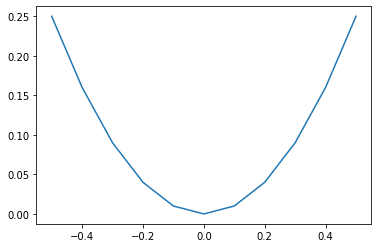

In [4]:
plt.plot(inputs, outputs)
plt.show()

Bây giờ chúng ta sẽ tạo hàm `generate_samples()` dùng để phát sinh các **input** cho GANs model.

In [5]:
def generate_samples(n=100):
    '''Phát sinh @n giá trị trong khoảng [-0.5, 0.5]'''
    X1 = np.random.rand(n) - 0.5
    
    '''Tạo output từ @X1'''
    X2 = X1 * X1
    
    '''Reshape lại thành mảng chứa @n mảng gồm 1 phần tử'''
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    '''Trả về một np-array có shape=(@n, 2)'''
    return np.hstack((X1, X2))

Bây giờ ta sẽ phát sinh 100 giá trị đầu vào bằng hàm `generate_samples()`.

In [6]:
data = generate_samples()

print(data)

[[ 3.66279852e-01  1.34160930e-01]
 [-2.55863814e-01  6.54662914e-02]
 [-2.81958172e-01  7.95004110e-02]
 [-1.64680146e-01  2.71195505e-02]
 [ 1.37230055e-01  1.88320879e-02]
 [-5.99929336e-03  3.59915208e-05]
 [-2.54907255e-01  6.49777088e-02]
 [ 1.60775772e-01  2.58488488e-02]
 [ 1.76211698e-01  3.10505624e-02]
 [-1.20263490e-01  1.44633070e-02]
 [-1.27683860e-01  1.63031681e-02]
 [-3.43801344e-01  1.18199364e-01]
 [-2.21311301e-01  4.89786921e-02]
 [ 4.79095894e-01  2.29532876e-01]
 [ 4.03949623e-01  1.63175298e-01]
 [-4.73527705e-01  2.24228487e-01]
 [-1.92712979e-01  3.71382921e-02]
 [-3.75013931e-01  1.40635448e-01]
 [-4.37133714e-01  1.91085884e-01]
 [ 1.12910181e-04  1.27487091e-08]
 [-2.41955415e-01  5.85424229e-02]
 [ 3.22704633e-01  1.04138280e-01]
 [-3.61988172e-01  1.31035437e-01]
 [ 5.43695501e-02  2.95604798e-03]
 [ 4.27273491e-01  1.82562636e-01]
 [-4.10131148e-01  1.68207559e-01]
 [ 3.38220339e-01  1.14392998e-01]
 [-4.65586331e-01  2.16770632e-01]
 [ 4.91503231e-01  2

Trực quan hóa `data`.

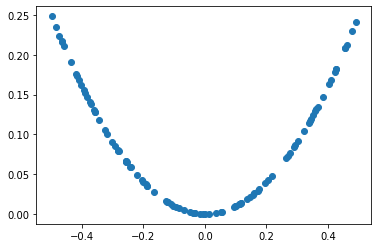

In [7]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Bây giờ chúng ta sẽ build Discriminator model.

Ở bài toán của chúng ta, Discriminator model nhận vào một giá trị và nó phải dự đoán xem giá trị này là real hay fake, nói cách khác Discriminator là một binary classifier, trong đó:
  * **Inputs**: là hai số thực.
  * **Outputs**:  phân loại nhị phân, cụ thể dự đoán một sample là real hay fake.

Chúng ta sẽ xây dựng kiến trúc cho Discriminator bao gồm 1 hidden layer với 25 neuron và dùng ReLU activation function.

Tiếp theo, chúng ta cần xác định **init random noise vector**, chúng ta sẽ khởi tạo vector này bằng một phương pháp là **He weight initialization**.

Output layer sẽ chỉ có 1 neuron và sẽ sử dụng sigmoid activation function.

Loss function mà chúng ta sử dụng sẽ là **binary cross-entropy**.

Optimizer mà chúng ta sẽ sử dụng là **Adam**.

Tiếp theo, metrics mà chúng ta sẽ dùng là **accuracy**.

Chúng ta sẽ bỏ tất cả những thứ này vào một hàm là `define_discriminator()`.

In [8]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    
    '''Biên dịch model'''
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Bây giờ chúng ta sẽ tạo Discriminator model thông qua hàm `define_discriminator()`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


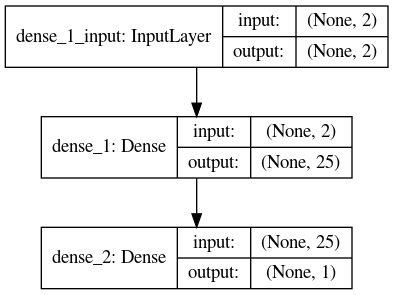

In [9]:
model = define_discriminator()

model.summary()
plot_model(model, to_file='./images/discriminator_plot.png',
           show_shapes=True, show_layer_names=True)

Bây giờ ta sẽ định nghĩa hàm `generate_real_sample()`, hàm này dùng để phát sinh các real sample, tức có label là $1$.

In [10]:
def generate_real_samples(n):
    X1 = np.random.rand(n) - 0.5
    X2 = X1*X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    
    return X, y

Tiếp theo, chúng ta sẽ định nghĩa một hàm với chức năng tương tự như hàm `generate_real_samples()` nhưng để phát sinh các fake sample, tức có label bằng $0$.

In [11]:
def generate_fake_samples(n):
    X1 = -1 + np.random.rand(n) * 2
    X2 = -1 + np.random.rand(n) * 2
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    
    y = np.zeros((n, 1))
    return X, y

Ở bước này, chúng ta định nghĩa hàm `train_discriminator()`, qua từng epoch với mỗi batch size, nó lấy phân nữa để phát sinh real sample và nữa còn lại phát sinh cho fake sample. Với từng sample set như vậy, tiến hành đào tạo cho model.

Ở cuối từng epoch, ta cho model dự đoán thử trên chính tập real và fake sample và đánh giá bằng accuracy.

In [12]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = n_batch // 2
    
    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(half_batch)
        model.train_on_batch(X_fake, y_fake)
        
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        
        print("At iteration {:03d}: accuracy on real: {:.5f} - accuracy on fake: {:.5f}".format(i, acc_real, acc_fake))

In [13]:
model = define_discriminator()
train_discriminator(model)

At iteration 000: accuracy on real: 1.00000 - accuracy on fake: 0.09375
At iteration 001: accuracy on real: 1.00000 - accuracy on fake: 0.07812
At iteration 002: accuracy on real: 1.00000 - accuracy on fake: 0.12500
At iteration 003: accuracy on real: 0.75000 - accuracy on fake: 0.17188
At iteration 004: accuracy on real: 0.78125 - accuracy on fake: 0.12500
At iteration 005: accuracy on real: 0.60938 - accuracy on fake: 0.28125
At iteration 006: accuracy on real: 0.46875 - accuracy on fake: 0.18750
At iteration 007: accuracy on real: 0.56250 - accuracy on fake: 0.25000
At iteration 008: accuracy on real: 0.42188 - accuracy on fake: 0.31250
At iteration 009: accuracy on real: 0.59375 - accuracy on fake: 0.32812
At iteration 010: accuracy on real: 0.46875 - accuracy on fake: 0.25000
At iteration 011: accuracy on real: 0.45312 - accuracy on fake: 0.39062
At iteration 012: accuracy on real: 0.53125 - accuracy on fake: 0.37500
At iteration 013: accuracy on real: 0.56250 - accuracy on fake: 

> **Nhận xét**:
> * Sau 1000 vòng lặp, model rất tốt trong việc xác định các fake sample, độ chính xác luôn nằm trong khoảng $\in [80, 90]$ phần trăm.

Bước này ta cùng định nghĩa Generator model, nó nhận input là một data point được lấy từ laten space sau đó nó tạo ra một new sample. Cuối cùng, output của chúng ta là một vector gồm hai phần tử $x$ và $x^2$.

Một latent variable là một biến ẩn và latent space là một vector space chứa các latent variable. Chúng ta có thể xác định size của latent space cho bài toán của chúng ta cũng như shape hoặc cách các latent variable phân phối trong latent space.

Nói chung, latent space sẽ vô nghĩa cho đến khi generator model bắt đầu sử dụng các biến trong latent space và gán ý nghĩa cho các biến này trong quá trình training.

Sau quá trình training, các variable trong latent space sẽ có mối quan hệ tương ứng với các variout ở output. Ở bài toán này, chúng ta sẽ định nghĩa một latent space gồm 5 dimension và sử dụng Gaussian distribution để phát sinh ra các latent variable trong latent space.

Các latent variable được phát sinh ngẫu nhiên từ Gaussian distribution, tức mean bằng $0$ và variance bằng $1$.

Tóm lại:
  * **Inputs**: một data point trong latent space - một vector gồm 5 phần tử được phát sinh ngẫu nhiên từ Gaussian distribution.
  * **Outputs**: một vector hai phần tử đại diện tương ứng cho một generated sample, ví dụ $\{x, x^2\}$.

Kiến trúc của Generator model như sau. Ta sẽ có một Dense hidden layer với 15 neuron và sử dụng ReLU activation function với các weight được phát sinh bằng **He uniform**, người ta đã chứng mình rằng [**He weights initialization** có mối quan hệ mạnh mẽ với **ReLU**](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404). Chúng ta dùng một linear activation function vì chúng ta muốn output vector với lần lượt phần tử đầu tiên sẽ được scale nằm trong đoạn $[-0.5, 0.5]$ và phần tử thứ hai là $[0, 0.25]$.

Bây giờ, chúng ta sẽ bỏ tất cả điều này vào hàm `define_generator()`.

In [14]:
def define_generator(latent_dim: int, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    
    return model

Bây giờ chúng ta sẽ thử **summary** generator model với latent dimension bằng $5$.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


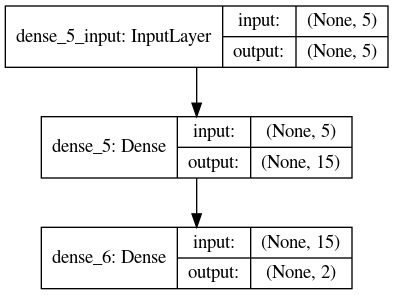

In [15]:
model = define_generator(5)

model.summary()
plot_model(model, to_file='./images/generator_plot.png',
           show_shapes=True, show_layer_names=True)

Tiếp theo, chúng ta sẽ định nghĩa một hàm là `generate_latent_point(latent_dim: int, n: int)`, chức năng của hàm này dùng để phát sinh ra `@n` latent variable rút ra từ Gaussian distribution với size của từng latent variable bằng với `@latent_dim`.

In [16]:
def generate_latent_points(latent_dim: int, n: int):
    x_input = np.random.rand(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    
    return x_input

Tiếp theo, chúng ta có thể dùng các latent variable phát sinh từ `generate_latent_points()` để làm input cho generator model - sau đó generator model phát sinh ra các generated sample từ các input này.

Chúng ta sẽ viết lại hàm `generate_fake_sample(generator, laten_dim, n)` dùng để phát sinh ra các fake sample, với ba tham số:
  * `@generator`: là model generator.
  * `@latent_dim`: là size của từng latent variable.
  * `@n`: là số latent variable mà ta muốn phát sinh, cũng chính là số generated sample mà ta muốn generator model trả về.

In [17]:
def generate_fake_samples(generator, latent_dim: int, n: int):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    
    '''Visualization'''
    plt.scatter(X[:, 0], X[:, 1])
    plt.show()

Bây giờ, chúng ta sẽ thử gọi hàm `generate_fake_samples()` mà ta vừa 
chỉnh sửa ở trên gồm $100$ latent variable với size của từng latent variable là $5$.

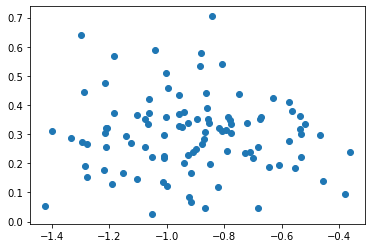

In [18]:
latent_dim = 5
model = define_generator(latent_dim)

generate_fake_samples(model, latent_dim, 100)

In [19]:
def generate_fake_samples(generator, latent_dim: int, n: int):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    
    return X, y

Ở bước này, ta sẽ tập trung vào bước build Generator model. Trước tiên ta nên nhớ lại Generator model sẽ tiến hành cập nhật các weight của nó dựa trên performance trả về của Discriminator model. Generator sẽ cập nhật các nhiều các weight với gradient lớn hơn nếu Discriminator model nhận diện các fake sample quá tốt do Generator phát sinh. Ngược lại các weight sẽ ít được cập nhật nếu Discriminator phân biệt kém giữa generated sample và real sample.

Cụ thể, chúng ta sẽ tạo một GANs model mà lần lượt Generator và Discriminator sẽ xếp chồng lên nhau sao cho Generator sẽ nhận input từ các latent variale lấy ra từ latent space - tiếp theo nó tạo ra các generated sample từ các latent variable này. Cuối cùng các generated sample được đưa trực tiếp vào Discriminator - tiến hành classification - sau cùng các kết quả trả về của GANs model được sử dụng để cập nhật weight cho Generator.

Lúc này, disciminator quan tâm đến việc phân biệt giữa real và fake sample. Trong khi ở generator chỉ quan tâm đến performance của discriminator trên các fake sample do nó phát sinh. Ta sẽ tạo một biến `@trainable` mang giá trị boolean để cho Discriminator biết khi nào Generator đã phát sinh xong các generated sample và sẵn sàng đưa vào Discriminator model.

Ngoài ra, chúng ta cần gắn nhãn các generated sample có class là `1` và Discriminator sẽ phân loại các sample mà nó cho là fake sample với class là `0` - hay nếu nhìn dưới góc nhìn giá trị xác suất chúng có giá trị nằm trong khoảng $(0.3, 0.5)$. Quá trình backpropagation sẽ update các weight của Generator với gradient lớn khi discriminator dự đoán đúng và nhỏ hơn khi discriminator dự đoán sai.

Nói tóm lại, ta sẽ định nghĩa GANs model của chúng ta bên trong một hàm `define_gan(generator, discriminator)` mà nó sẽ là một model lớn chứa hai model nhỏ hơn là `@generator` và `@discriminator`, ngoài ra trong model lớn này ta định nghĩa thêm một boolean variable `@trainable` dùng để cho `@discriminator` biết đã có generated sample cho quá trình training của nó chưa. Model lớn này sẽ dùng **binary cross-entropy** cho loss function và sử dụng **Adam** ở optimizer.

In [20]:
def define_gan(generator, discriminator):
    '''Thêm biến @trainable vào @discriminator'''
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

Bây giờ chúng ta sẽ định nghĩa một GANs model từ hàm `define_gan()` bên trên với latent space có size là $5$.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


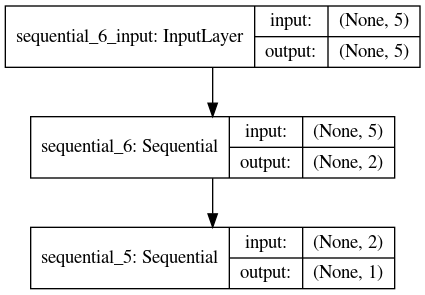

In [21]:
latent_dim = 5

discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

gan_model.summary()
plot_model(gan_model, to_file='./images/gan_plot.png', 
           show_shapes=True, show_layer_names=True)

Tiếp theo, ta định nghĩa một hàm `train_gan(gan_model, latent_dim: int, n_epochs=10_000, n_batch=128)`. Hàm này xử lí việc phát sinh ra các latent variable và xem nó là một batch - tiếp theo đánh nhãn có các generated sample được phát sinh từ generator bởi các latent variable này là $1$ _(tức fake sample)_, cuối cùng bỏ toàn bộ vào hàm `train_on_batch()` và lặp lại quá trình này đến epoch cuối cùng.

Qua từng epoch như vậy, Generator sẽ được điều chỉnh các weight thông qua performance của Discriminator.

In [22]:
def train_gan(gan_model, latent_dim: int, n_epochs=10_000, n_batch=128):
    for _ in range(n_epochs):
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.gan_model.train_on_batch(x_gan, y_gan)

In [23]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    print(f"Evaluation at epoch {(epoch + 1):05d} - acc on real: {acc_real:.5f} - acc on fake: {acc_fake:.05f}")
    
    plt.scatter(x_real[:, 0], x_real[:, 1], color="green")
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='red')
    
    filename = f"./images/generated_plot_e{(epoch + 1):05d}"
    plt.savefig(filename)
    plt.close()

Cuối cùng, chúng ta định nghĩa một hàm là `train()` dùng để tổng hợp mọi thứ từ trước cho đến giờ.

In [24]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10_000, n_batch=128, n_eval=2000):
    half_batch = n_batch // 2
    for i in range(n_epochs):
        '''Phát sinh real sample'''
        x_real, y_real = generate_real_samples(half_batch)
        
        '''Phát sinh fake sample từ generator'''
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        '''Cập nhật weight cho discriminator'''
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        '''Phát sinh @n_batch latent variable từ Gaussian distribution cho generator'''
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        
        '''Cập nhật weight cho generator qua performance của discriminator'''
        gan_model.train_on_batch(x_gan, y_gan)
        
        if not (i + 1) % n_eval: summarize_performance(i, g_model, d_model, latent_dim)

In [25]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

train(generator, discriminator, gan_model, latent_dim)

/home/manhcuong/anaconda3/envs/tensor2x/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Evaluation at epoch 02000 - acc on real: 0.46000 - acc on fake: 1.00000
Evaluation at epoch 04000 - acc on real: 0.40000 - acc on fake: 1.00000
Evaluation at epoch 06000 - acc on real: 0.52000 - acc on fake: 0.00000
Evaluation at epoch 08000 - acc on real: 0.47000 - acc on fake: 1.00000
Evaluation at epoch 10000 - acc on real: 0.48000 - acc on fake: 0.15000
